In [65]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import skimage
import math
from scipy import ndimage
from matplotlib.path import Path

smart content aware noise removal could be one idea to improve.
working fine all images.
gaussianblur inbuilt works only on even window sizes

In [2]:
def find_scan_screenshot(img):
    # return 0 for scan/screenshot and 1 for photograph
    total_pixels = img.shape[0]*img.shape[1]
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    prop = np.sum(hist[15:241])/total_pixels
    if prop<0.1:
        return 0
    else:
        return 1

In [3]:
def binarization_scans(img):
    # using inbuilt otsu's method..Implement later
    _,im = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return im
#handle very small images later 
def binarization_photos(img):
    high_res = 0
    if img.size>2000*1000:
        high_res = 1
    
    if high_res==1:
        img = cv2.GaussianBlur(img,(9,9),3) # fails for even
    
    window_size = int(min(img.shape[0],img.shape[1])/60)
    if window_size%2==0:
        window_size+=1 #cv2.adaptiveThreshold accepts only odd window sizes
    
    thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,window_size,10)
    return thresh_img
def morph_proc(img):
    img = 255 - img
    img[img==255] = 1
    kernel = np.ones((3,3))
    kernel1 = np.ones((5,5))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) 
    closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
    filled = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
    filled[filled==1] = 255
    return 255-filled

In [4]:
def binarize_input(img):
    img_type = find_scan_screenshot(img)
    if img_type==0:
        print("Scan/Screenshot")
    else:
        print("Photograph")
    if img_type==0:
        new_img = binarization_scans(img)
    else:
        new_img = binarization_photos(img)
        new_img = morph_proc(new_img)
    return new_img

../input/eq8_hr.jpg


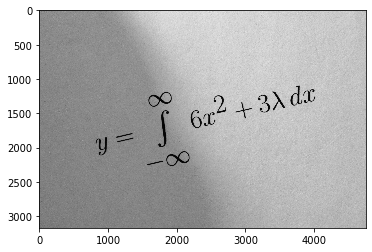

Photograph


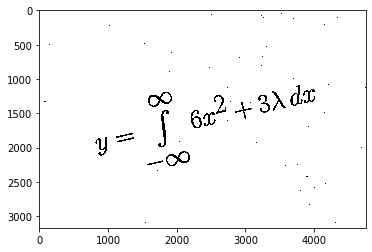

../input/eq2_hr.jpg


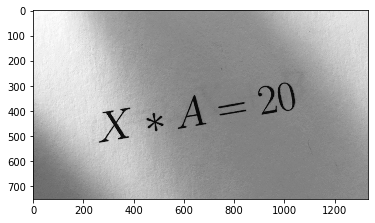

Photograph


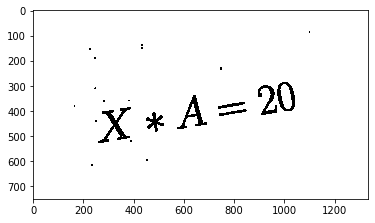

../input/eq6_hr.jpg


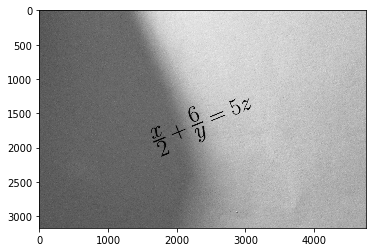

Photograph


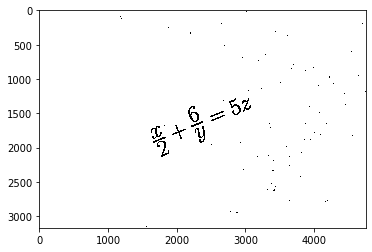

../input/eq7_hr.jpg


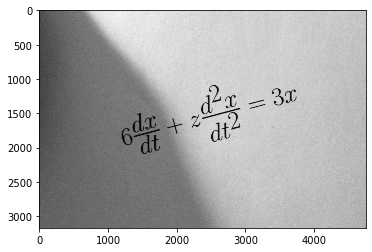

Photograph


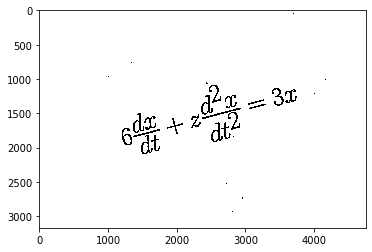

../input/eq1_hr.jpg


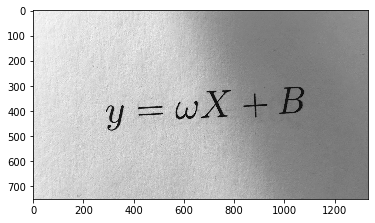

Photograph


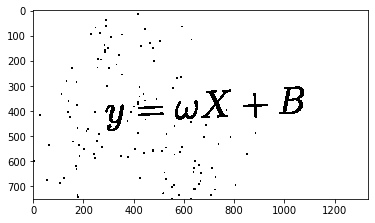

../input/eq3_hr.jpg


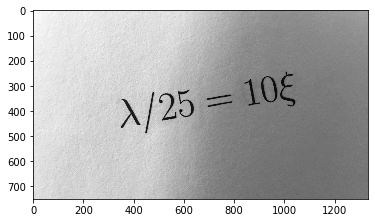

Photograph


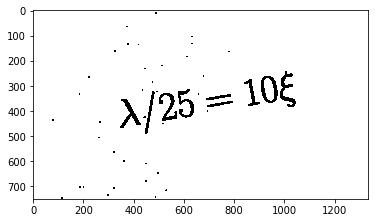

../input/eq9_hr.jpg


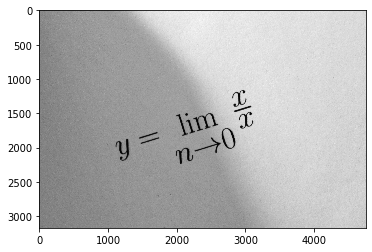

Photograph


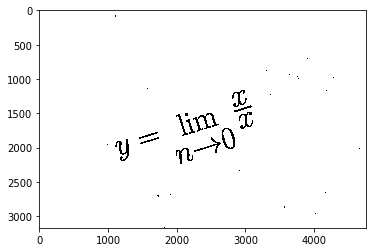

../input/demo_equation_hr.jpg


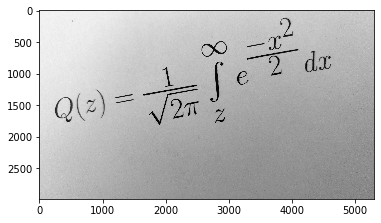

Photograph


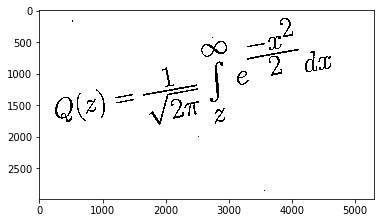

../input/eq5_hr.jpg


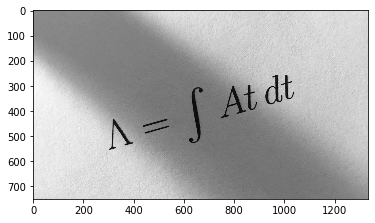

Photograph


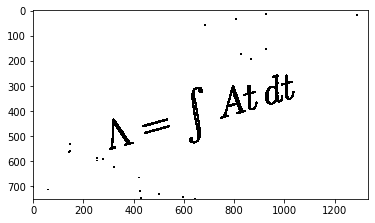

In [44]:
directory = "../input/"
for filename in os.listdir("../input/"):
    try:
        img_name = os.path.join(directory, filename)
        print(img_name)
        img = cv2.imread(img_name,0)
        plt.imshow(img,cmap='gray')
        plt.show()
        new_img = binarize_input(img)
        plt.imshow(new_img,cmap='gray')
        plt.show()
    except :
        pass
    
# remove very small images maybe based on area after connected comp analysis

Photograph


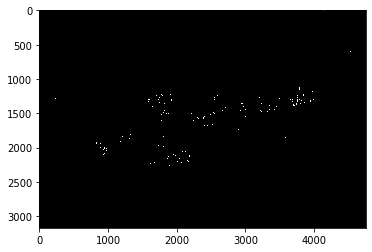

1
Angle is -12.932608396739516


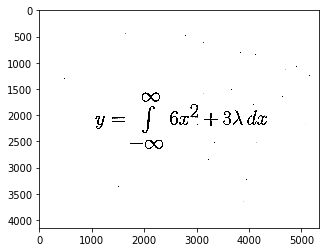

In [107]:
# + vunte panicheyadam ledhu image loo
img = cv2.imread("../input/eq8_hr.jpg",0)
new_img = binarize_input(img)
img_edges = cv2.Canny(img, 100, 100, apertureSize=3)
plt.imshow(img_edges,cmap='gray')
plt.show()

lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

angles = []

for x1, y1, x2, y2 in lines[0]:
    cv2.line(new_img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)
print(len(angles))
median_angle = np.mean(angles[:4])
img_rotated = skimage.transform.rotate(new_img, median_angle, resize=True, cval=1, mode ='constant')
# img_rotated = img_rotated * 255

print ("Angle is {}".format(median_angle))
plt.imshow(img_rotated,cmap="gray")

In [109]:
def check_contains(bbox1, bbox2): 
    '''check if bbox2 is contained in bbox1'''
    if (bbox1[0]<bbox2[0]) and (bbox1[2]>bbox2[2]) and (bbox1[1]<bbox2[1]) and (bbox1[3]>bbox2[3]):
        return True
    return False
    

In [111]:
def segmentation(im):
    plt.imshow(im,cmap='gray')
    plt.show()
    neg_im = 1-im
    kernel = np.ones((3,3), np.uint8) 
    neg_im_erosion = cv2.erode(neg_im, kernel, iterations=1) 
    edge_map = np.logical_xor(neg_im,neg_im_erosion)
    plt.imshow(edge_map,cmap="gray")
    plt.show()
    labels = skimage.measure.label(edge_map, connectivity=2) #connectivity-2 => neighbours 8
    reg = skimage.measure.regionprops(labels)
#     print(len(reg))
    bboxs = [i.bbox for i in reg] #min_row, min_col, max_row, max_col
    centroids = [i.centroid for i in reg]
    convex_hulls = [i.convex_image for i in reg]
    imgs = [i.image for i in reg]
    ign_ind = []
#     need to add additional check with edge map
    for i in range(0,len(bboxs)): #checks if 'j' is contained in i
        for j in range(0,len(bboxs)):
            if bboxs[i]==bboxs[j]:
                continue
            
            contains = check_contains(bboxs[i],bboxs[j])
            if contains:
                ign_ind.append(j)
                
    
#     for i in ign_ind:
#         print(bboxs[i])
#         plt.imshow(im[bboxs[i][0]:bboxs[i][2],bboxs[i][1]:bboxs[i][3]],cmap='gray')
#         plt.show()
#     plt.imshow(imgs[i],cmap=plt.cm.gnuplot)
    imgs_sizes = []
    for i in range(0,len(imgs)):
        if i in ign_ind:
            continue
        imgs_sizes.append(imgs[i].size)
        plt.imshow(imgs[i],cmap="gray")
        plt.show()
    
    imgs_sizes = np.sort(imgs_sizes)
    print(imgs_sizes)

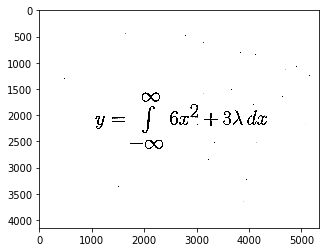

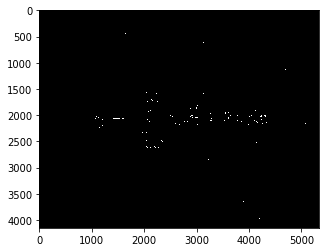

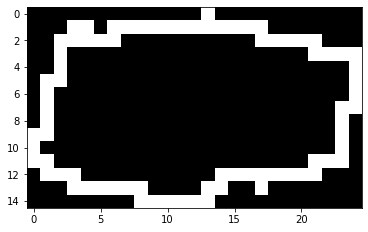

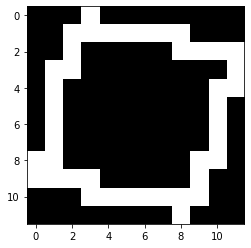

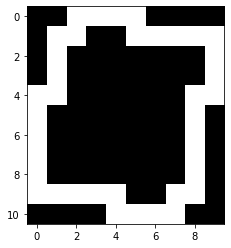

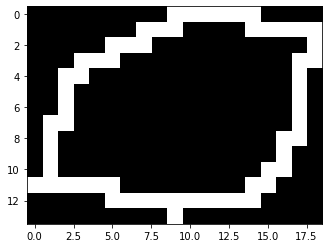

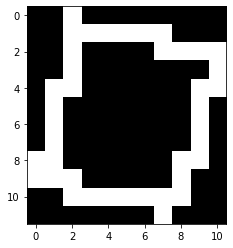

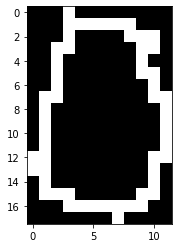

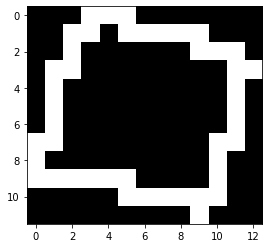

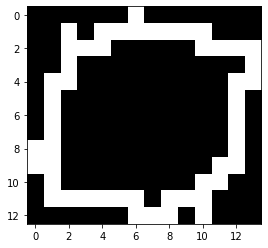

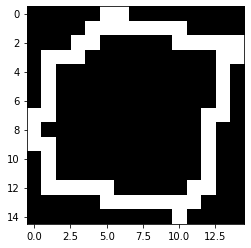

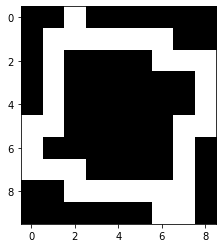

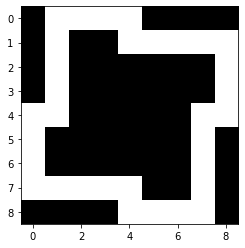

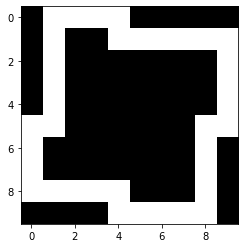

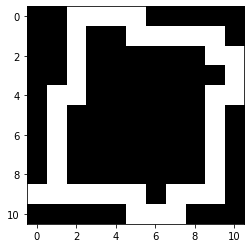

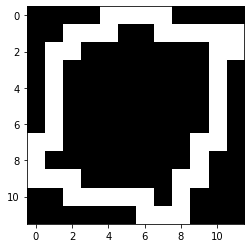

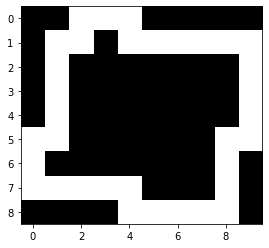

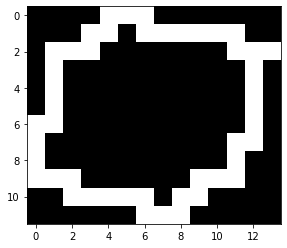

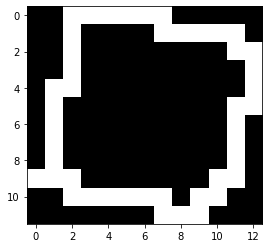

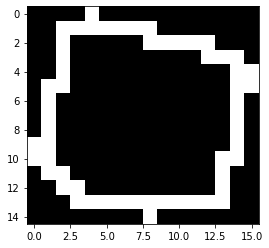

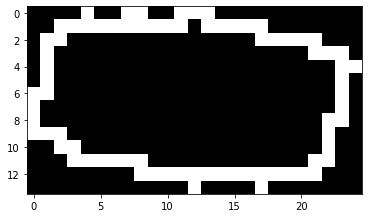

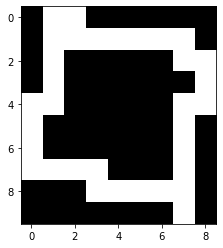

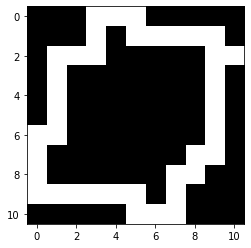

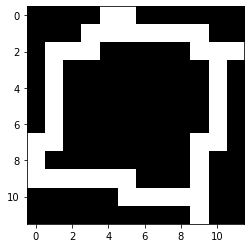

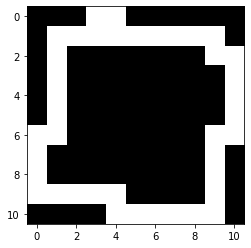

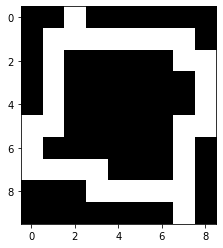

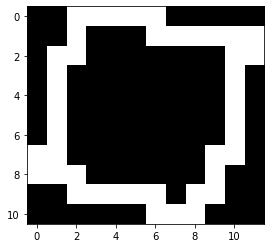

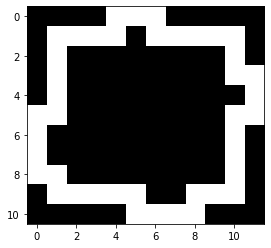

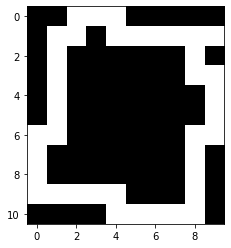

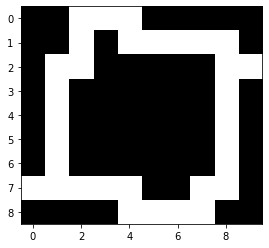

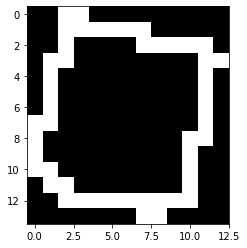

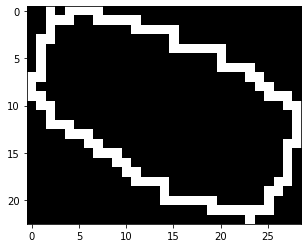

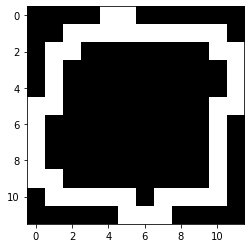

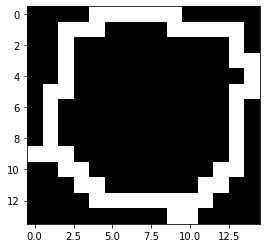

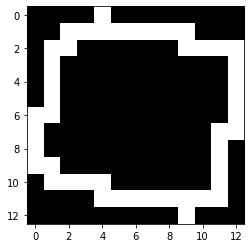

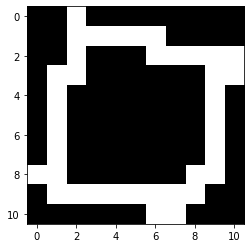

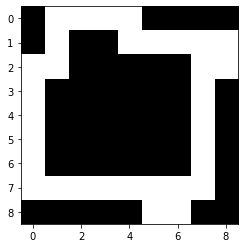

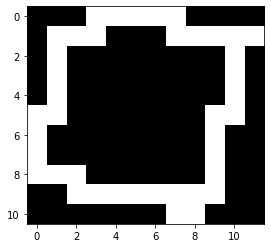

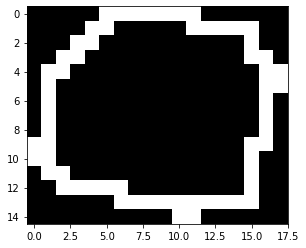

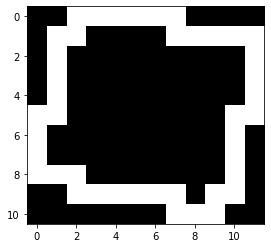

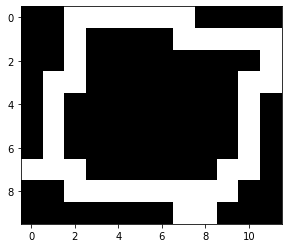

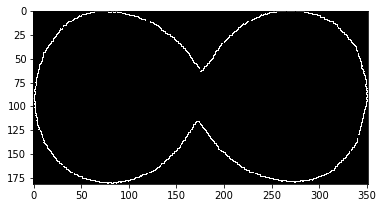

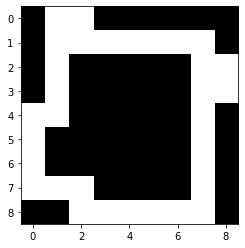

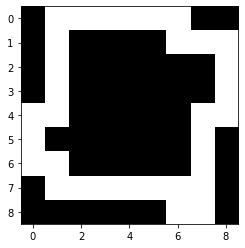

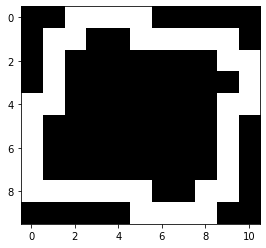

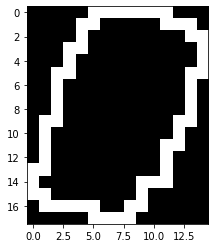

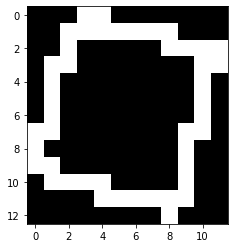

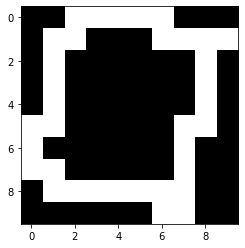

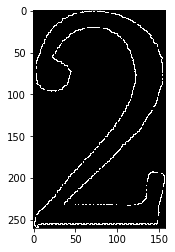

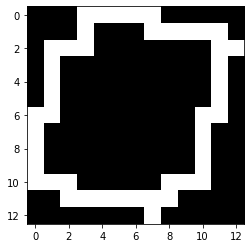

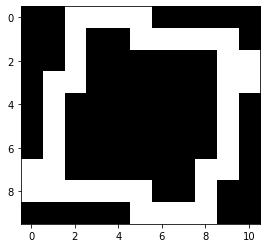

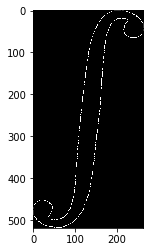

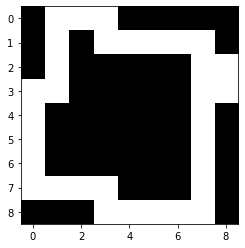

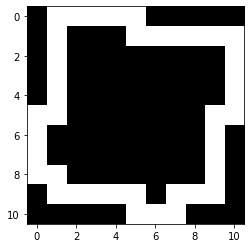

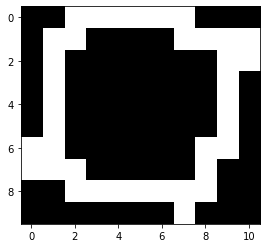

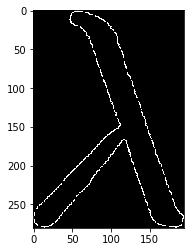

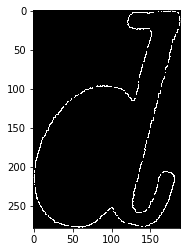

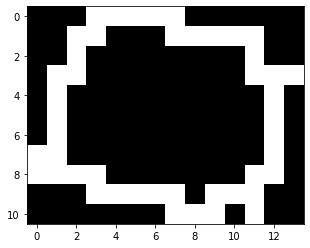

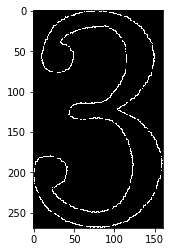

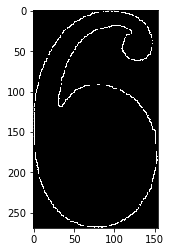

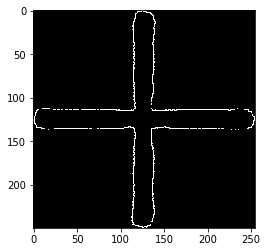

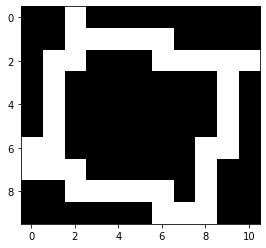

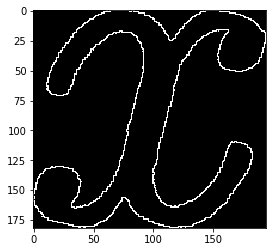

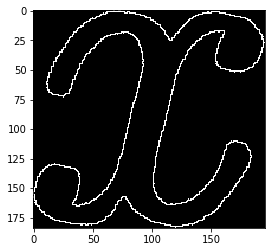

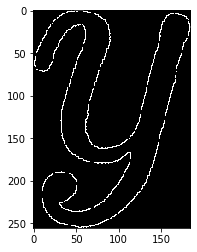

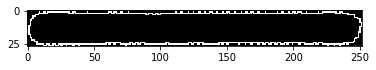

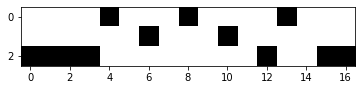

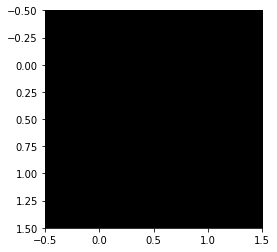

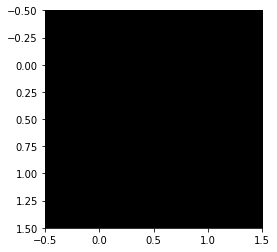

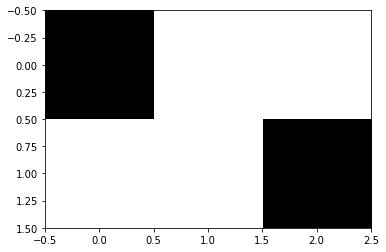

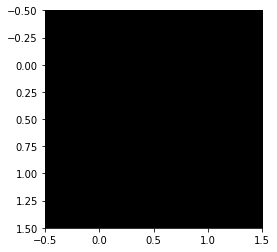

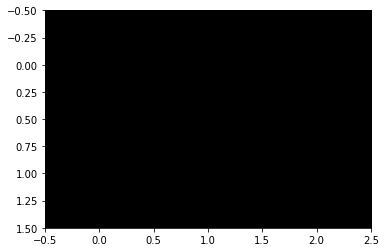

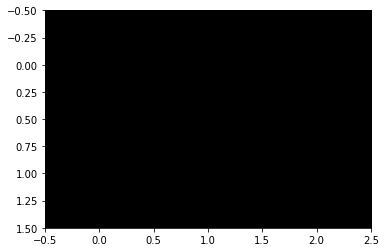

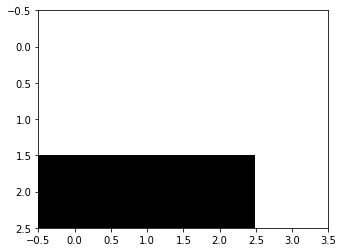

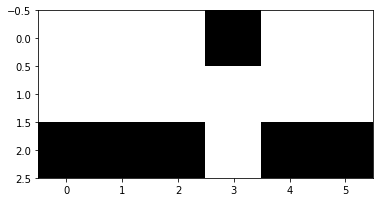

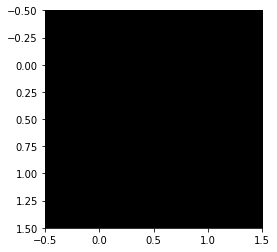

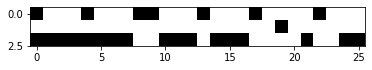

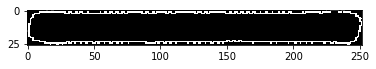

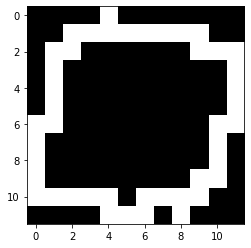

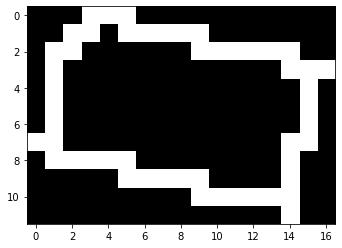

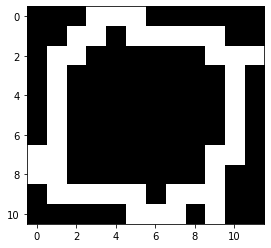

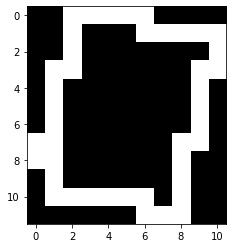

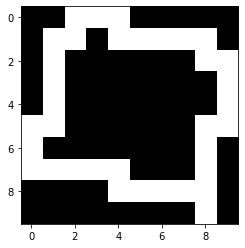

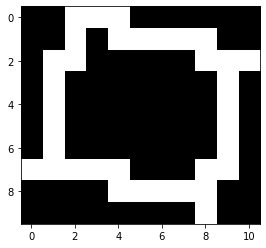

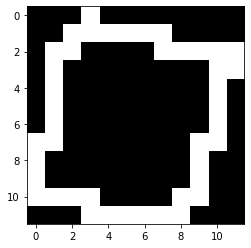

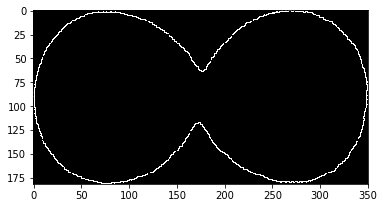

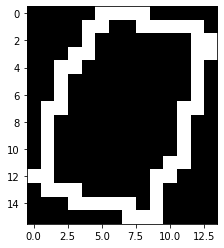

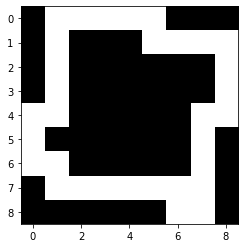

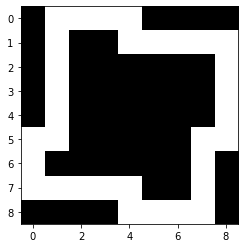

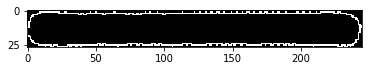

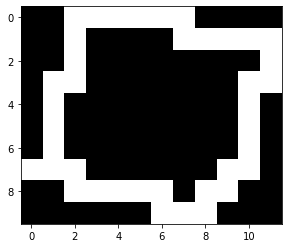

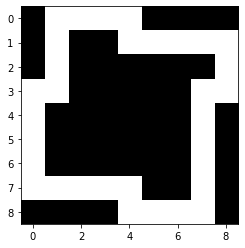

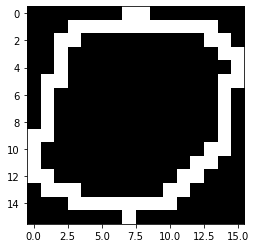

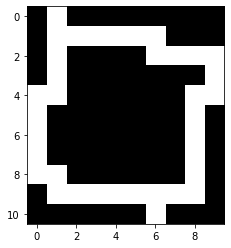

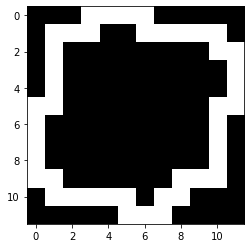

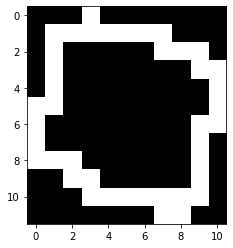

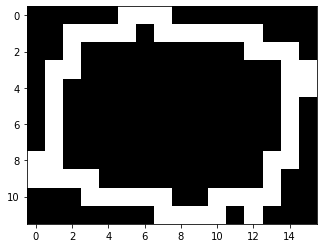

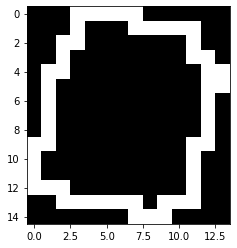

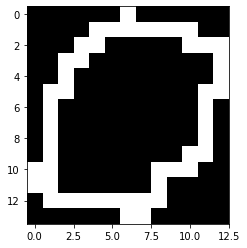

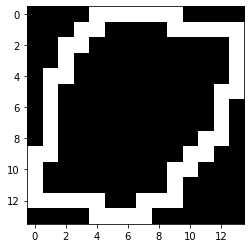

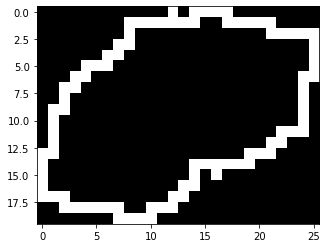

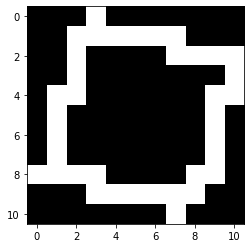

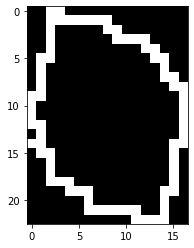

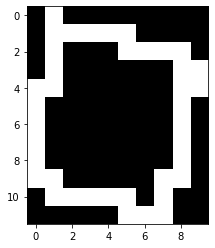

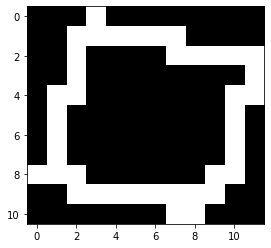

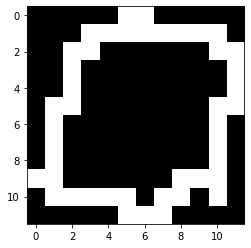

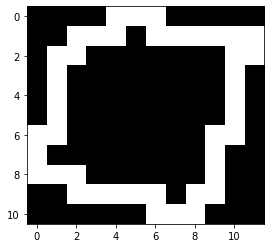

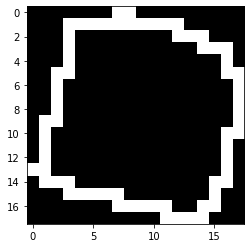

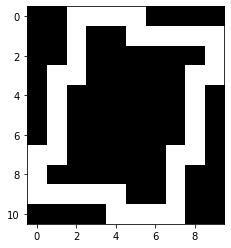

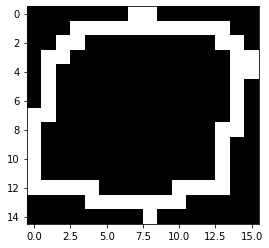

[     4      4      4      4      6      6      6     12     18     51
     78     81     81     81     81     81     81     81     81     90
     90     90     90     90    100    100    100    110    110    110
    110    110    110    110    110    110    120    120    120    121
    121    121    121    121    121    132    132    132    132    132
    132    132    132    132    132    144    144    144    144    144
    144    144    144    154    156    156    156    168    169    169
    182    182    182    192    196    204    210    210    216    224
    225    240    240    256    266    270    270    324    350    375
    391    520    667   6552   6615   6804  35490  36064  41080  41426
  43040  47360  52731  54795  63750  63882  64064 136497]


In [112]:
segmentation(img_rotated)